In [2]:
import numpy as np
from scipy.linalg import sqrtm, inv
import matplotlib.pyplot as plt

# 日资料分析

In [8]:
import pandas as pd
start_date = pd.to_datetime("1979/01/01", format="%Y/%m/%d")
end_date = pd.to_datetime("2017-01-01", format="%Y-%m-%d")
#end_time = start_time + pd.Timedelta(days=11687)
days_difference = (end_date - start_date).days
#end_time.strftime("%Y-%m-%d")
days_difference

13880

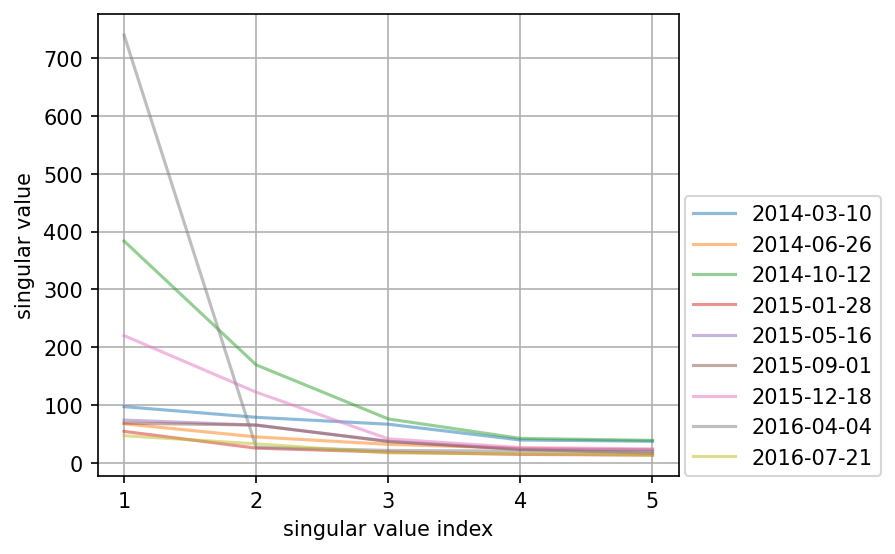

In [9]:
def plot_singular(test_id_first, seeds = 1, length=1, window=5, start=1, end=16435, interval=108, sigmas=True):
    start_date = pd.to_datetime("1979/01/01", format="%Y/%m/%d")
    jacs = {i:[] for i in range(start, end, interval)}
    for expid in range(seeds):
        test_id = test_id_first + str(expid)
        for i in range(start, end, interval):
            str_i = f'{i:04d}'
            mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy').reshape(length*37, -1).astype(float)
            mat = mat.T @ mat
            if sigmas:
                L = np.load(f'../results/cov_L/{test_id}/L_{str_i}.npy')
                mat = mat.T @ inv(L[0]) @ mat
            u, s, vt = np.linalg.svd(mat)
            jacs[i].append(s)

    plt.figure(figsize=(5,4),dpi=150)
    for i in range(start, end, interval):
        time = start_date + pd.Timedelta(days=i)
        jac_arr = np.array(jacs[i])
        jac_mean = np.mean(jac_arr, axis=0)
        jac_std = np.std(jac_arr, axis=0)
        plt.plot(jac_mean[:window], label=time.strftime("%Y-%m-%d"), alpha=0.5)
        plt.fill_between(range(window), jac_mean[:window]+jac_std[:window], jac_mean[:window]-jac_std[:window], alpha=0.15)
    plt.grid()
    plt.xlabel("singular value index")
    plt.xticks(range(window), [1+i for i in range(window)])
    plt.ylabel("singular value")
    plt.legend(loc=[1.01,0])


test_id = 'long_term_forecast_iT_cov_qbo_daily_iTransformer_QBO_ftM_sl96_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_lam0.0_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, start=12852, end=13824, interval=108, window=5, sigmas=False)

In [ ]:
from scipy.linalg import eig
def gini(jac_mean):
    return np.cumsum(jac_mean)[-1] / len(jac_mean) - 0.5
def plot_singular_cum(test_id_first, seeds = 1, length=1, window=5, sigmas=True):
    jacs = {i:[] for i in range(852, 960, 12)}
    for expid in range(seeds):
        test_id = test_id_first + str(expid)
        for i in range(852, 960, 12):
            str_i = f'{i:04d}'
            mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy').reshape(length*37, -1).astype(float)
            mat = mat.T @ mat
            if sigmas:
                L = np.load(f'../results/cov_L/{test_id}/L_{str_i}.npy')
                mat = mat.T @ inv(L[0]) @ mat
            u, s, vt = np.linalg.svd(mat)
            #mat = mat.T @ inv(msed) @ mat
#             eigenvalues, eigenvectors = eig(mat)
            jacs[i].append(s)

    plt.figure(figsize=(5,4),dpi=150)
    gn_dic = {}
    for i in range(852, 960, 12):
        jac_arr = np.array(jacs[i])
        jac_mean = np.mean(jac_arr, axis=0)
        jac_mean = np.cumsum(jac_mean)
        jac_mean /= jac_mean[-1]
        gn = gini(jac_mean)
        gn_dic[str(1941+i//12)] = gn
        plt.plot(jac_mean[:window], label=str(1941+i//12), alpha=0.5)

    plt.xlabel("singular value index")
    #plt.xticks(range(window), [1+i for i in range(window)])
    plt.ylabel("singular cumsum(normalized)")
    plt.ylim([0.4,1])
    plt.xlim([0,50])
    plt.legend(loc=[1.01,0])

# 对f(x)的Jacobian矩阵做SVD分解

In [2]:
#test_id_first = "long_term_forecast_data_mean_996_37_iTransformer_QBO_ftM_sl1_pl1_dm512_nh8_el4_dl1_df512_fc3_ebtimeF_dtTrue_Exp_"
def plot_singular(test_id_first, seeds = 1, length=1, window=5, sigmas=True):
    jacs = {i:[] for i in range(852, 960, 12)}
    for expid in range(seeds):
        test_id = test_id_first + str(expid)
        for i in range(852, 960, 12):
            str_i = f'{i:04d}'
            mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy').reshape(length*37, -1).astype(float)
            mat = mat.T @ mat
            if sigmas:
                L = np.load(f'../results/cov_L/{test_id}/L_{str_i}.npy')
                mat = mat.T @ inv(L[0]) @ mat
            u, s, vt = np.linalg.svd(mat)
            jacs[i].append(s)

    plt.figure(figsize=(5,4),dpi=150)
    for i in range(852, 960, 12):
        jac_arr = np.array(jacs[i])
        jac_mean = np.mean(jac_arr, axis=0)
        jac_std = np.std(jac_arr, axis=0)


        plt.plot(jac_mean[:window], label=str(1941+i//12), alpha=0.5)
        plt.fill_between(range(window), jac_mean[:window]+jac_std[:window], jac_mean[:window]-jac_std[:window], alpha=0.15)
    plt.grid()
    plt.xlabel("singular value index")
    plt.xticks(range(window), [1+i for i in range(window)])
    plt.ylabel("singular value")
    plt.legend(loc=[1.01,0])
    
#plot_singular(test_id_first, seeds=1, length=1)

In [12]:
from scipy.linalg import eig

def gini(jac_mean):
    return np.cumsum(jac_mean)[-1] / len(jac_mean) - 0.5

test_id = 'nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_'    
def plot_singular_cum(test_id_first, seeds = 1, length=1, window=5, sigmas=True):
    jacs = {i:[] for i in range(852, 960, 12)}
    for expid in range(seeds):
        test_id = test_id_first + str(expid)
        for i in range(852, 960, 12):
            str_i = f'{i:04d}'
            mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy').reshape(length*37, -1).astype(float)
            mat = mat.T @ mat
            if sigmas:
                L = np.load(f'../results/cov_L/{test_id}/L_{str_i}.npy')
                mat = mat.T @ inv(L[0]) @ mat
            u, s, vt = np.linalg.svd(mat)
            #mat = mat.T @ inv(msed) @ mat
#             eigenvalues, eigenvectors = eig(mat)
            jacs[i].append(s)

    plt.figure(figsize=(5,4),dpi=150)
    gn_dic = {}
    for i in range(852, 960, 12):
        jac_arr = np.array(jacs[i])
        jac_mean = np.mean(jac_arr, axis=0)
        jac_mean = np.cumsum(jac_mean)
        jac_mean /= jac_mean[-1]
        gn = gini(jac_mean)
        gn_dic[str(1941+i//12)] = gn
        plt.plot(jac_mean[:window], label=str(1941+i//12), alpha=0.5)

    plt.xlabel("singular value index")
    #plt.xticks(range(window), [1+i for i in range(window)])
    plt.ylabel("singular cumsum(normalized)")
    plt.ylim([0.4,1])
    plt.xlim([0,50])
    plt.legend(loc=[1.01,0])
    return gn_dic
    

{'2012': 0.49165494044957314,
 '2013': 0.48574397714812023,
 '2014': 0.48079627094885424,
 '2015': 0.4951347171992805,
 '2016': 0.48587819172027036,
 '2017': 0.48989277624858296,
 '2018': 0.4933395682578553,
 '2019': 0.48694530395924673,
 '2020': 0.48845702101878885}

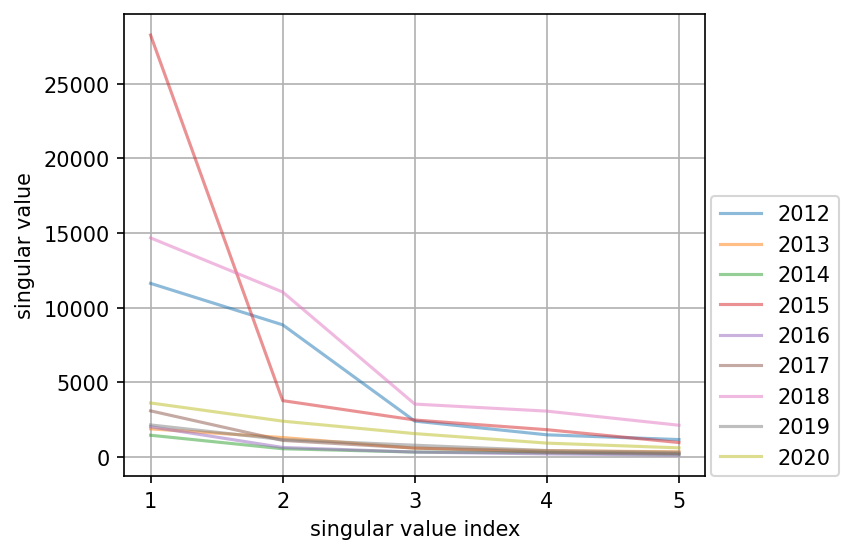

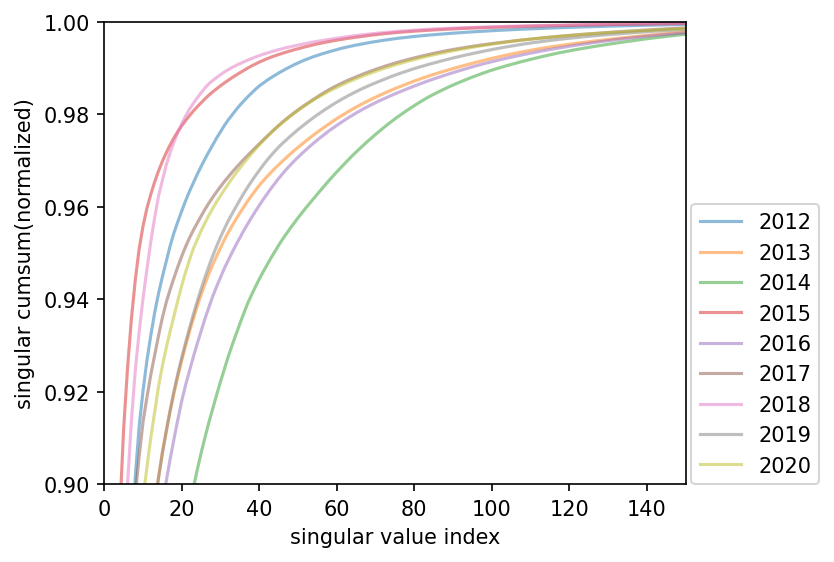

In [8]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_ebtimeF_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=False)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': 0.46882739126864637,
 '2013': 0.46297571668501103,
 '2014': 0.46432941514132575,
 '2015': 0.485812143761151,
 '2016': 0.46455903133196075,
 '2017': 0.4636361990094394,
 '2018': 0.48728600061415617,
 '2019': 0.4650025419339191,
 '2020': 0.48979090001029524}

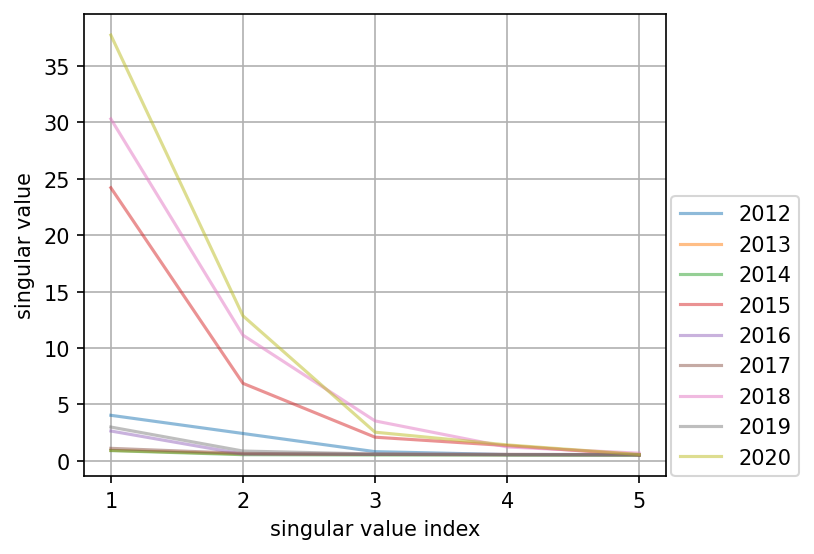

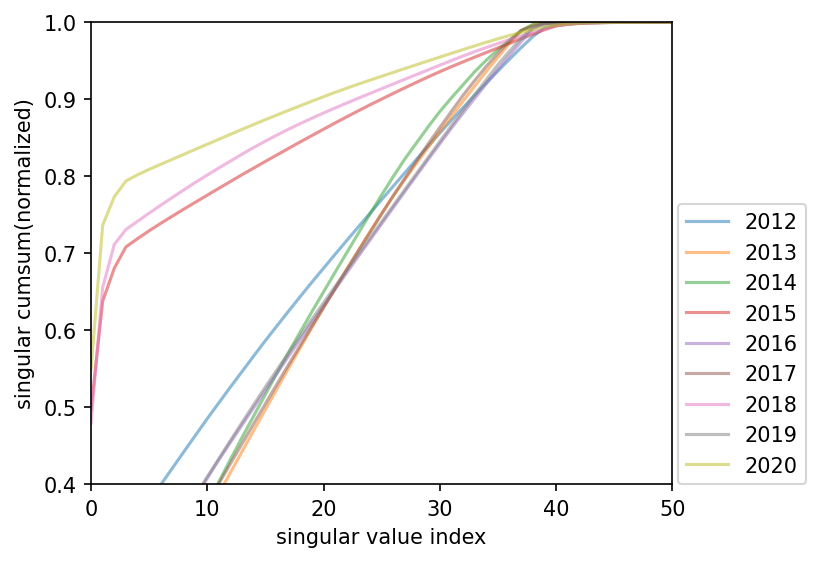

In [13]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_lam0.001_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=True)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=True)
gn_dic

{'2012': 0.4888285402201138,
 '2013': 0.47988910520051764,
 '2014': 0.4837338777626421,
 '2015': 0.49367503342943186,
 '2016': 0.4826291302058978,
 '2017': 0.4790586287605122,
 '2018': 0.49257027250696517,
 '2019': 0.48480844346317176,
 '2020': 0.4943837218406518}

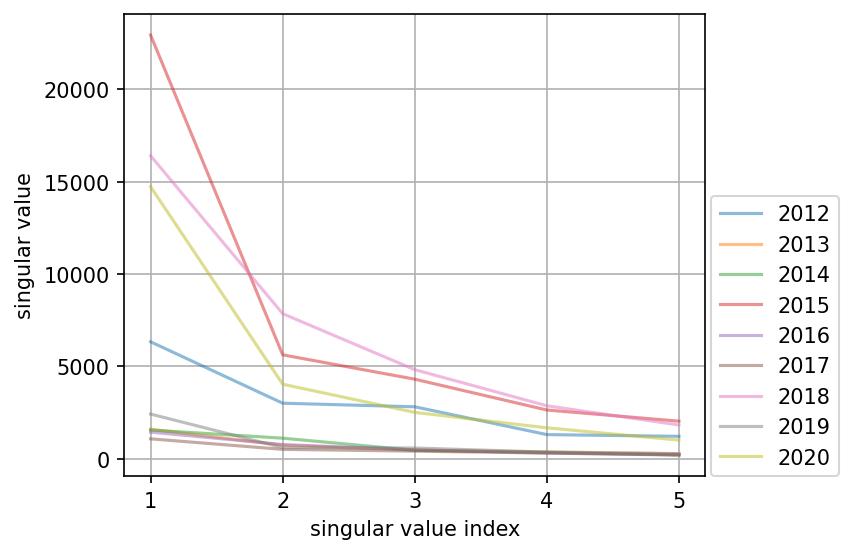

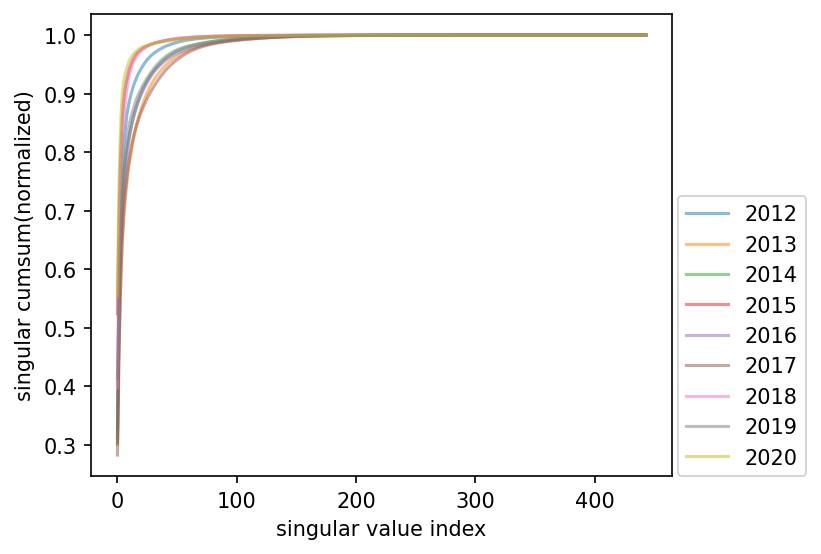

In [4]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_lam0.0_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=False)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': 0.4630018170385376,
 '2013': 0.46224250516682075,
 '2014': 0.4624851810271845,
 '2015': 0.46182952496477014,
 '2016': 0.4626919236088003,
 '2017': 0.46411287126077316,
 '2018': 0.46191611936155363,
 '2019': 0.463875109049132,
 '2020': 0.4615913403378955}

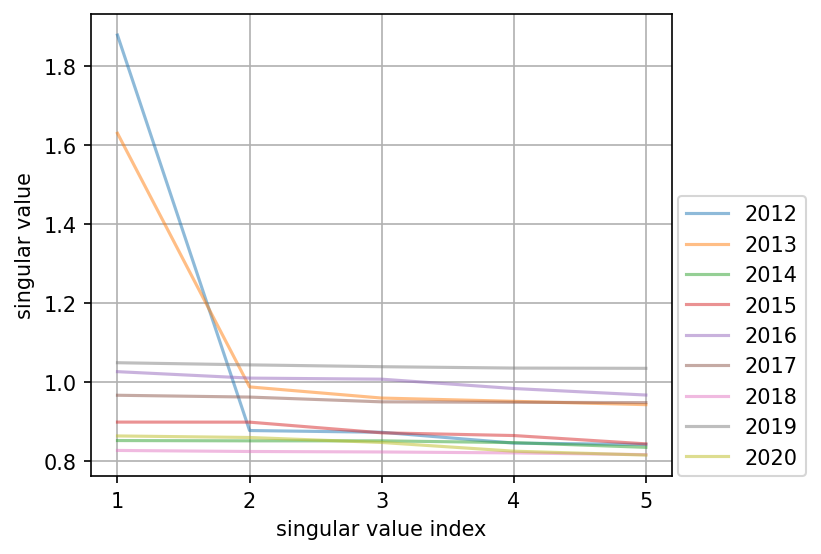

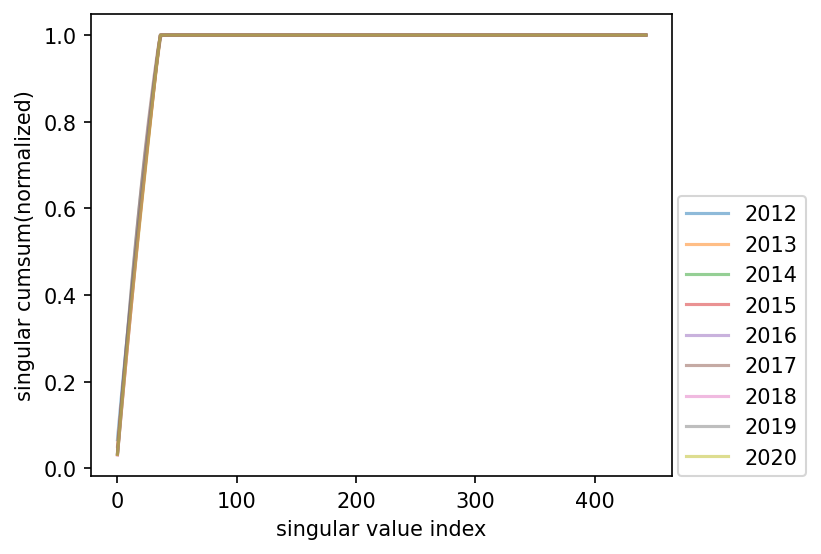

In [6]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_lam0.02_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=True)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=True)
gn_dic

{'2012': 0.48590747474373874,
 '2013': 0.4895152647380705,
 '2014': 0.46569377657198396,
 '2015': 0.4959524702032144,
 '2016': 0.46579055763141886,
 '2017': 0.48178316621690553,
 '2018': 0.49992940912820594,
 '2019': 0.4847818354772516,
 '2020': 0.46905325741605775}

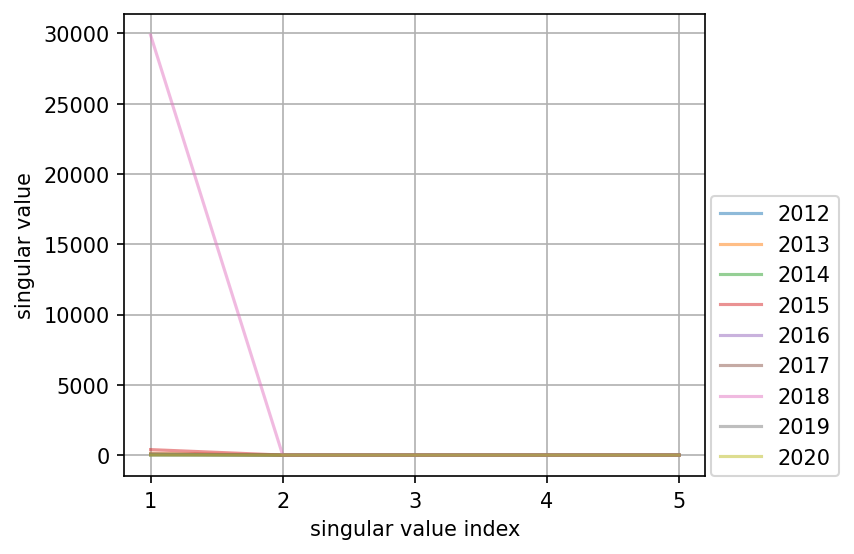

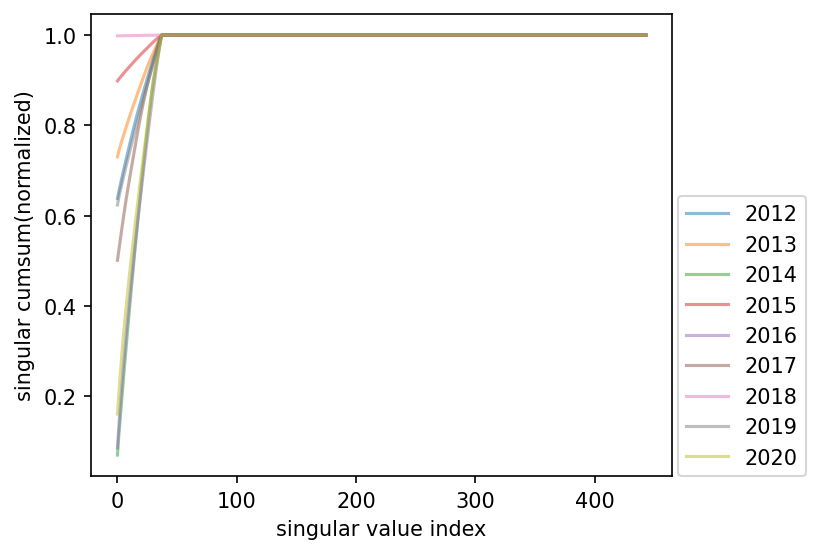

In [8]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_lam0.0005_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=True)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=True)
gn_dic

{'2012': 0.4192268132761324,
 '2013': 0.39242569156887785,
 '2014': 0.3960491861568777,
 '2015': 0.43173446719029285,
 '2016': 0.3922501151393507,
 '2017': 0.3895384748438233,
 '2018': 0.43391443776061167,
 '2019': 0.3956114377996274,
 '2020': 0.4202196331490061}

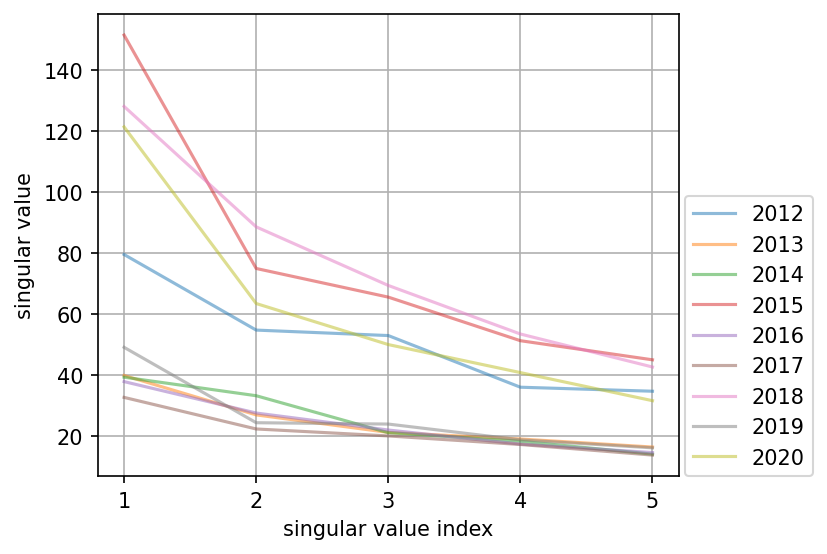

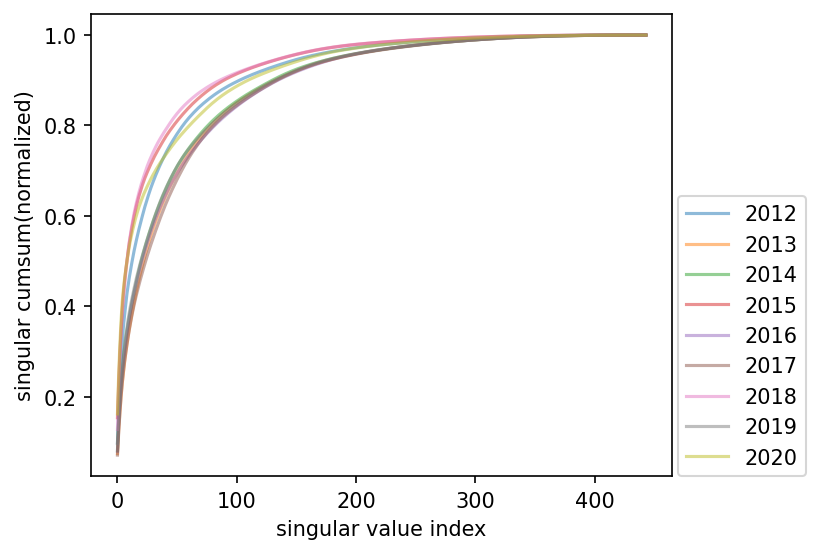

In [9]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_ebtimeF_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=False)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': 0.4235649840392566,
 '2013': 0.3923815865379351,
 '2014': 0.3846927954140963,
 '2015': 0.428357511175966,
 '2016': 0.386683695297121,
 '2017': 0.40092965154105975,
 '2018': 0.4366641201868796,
 '2019': 0.397507267454158,
 '2020': 0.4039684926087005}

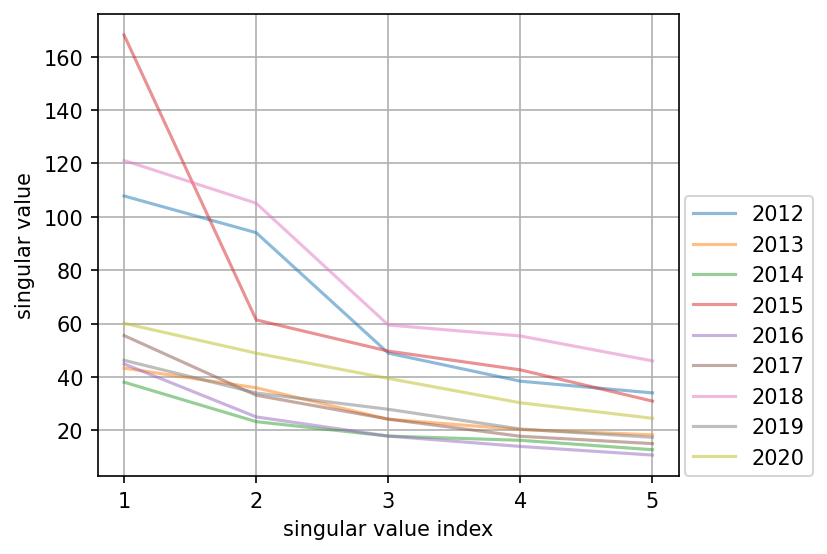

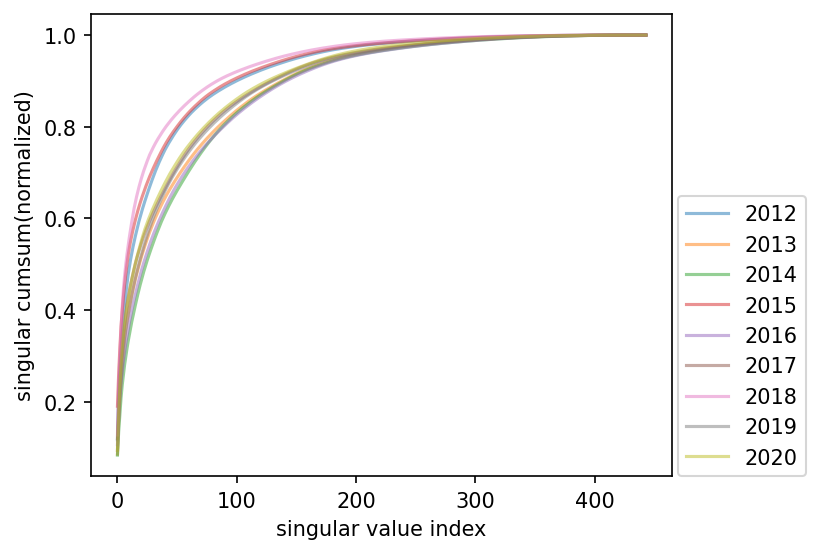

In [5]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_ebtimeF_dtTrue_Exp_'
test_id0 = 'nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_'
#test_id = "nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_"
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=False)
#plot_singular(test_id0, seeds = 1, length=12, window=5, sigmas=False)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
#gn_dic0 = plot_singular_cum(test_id0, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': np.float64(0.4127916855838143),
 '2013': np.float64(0.4034898068651721),
 '2014': np.float64(0.39813582384693424),
 '2015': np.float64(0.4133884032923364),
 '2016': np.float64(0.3958277977029685),
 '2017': np.float64(0.3965376226459141),
 '2018': np.float64(0.4122596433601924),
 '2019': np.float64(0.40057195660876466),
 '2020': np.float64(0.4043368074273893)}

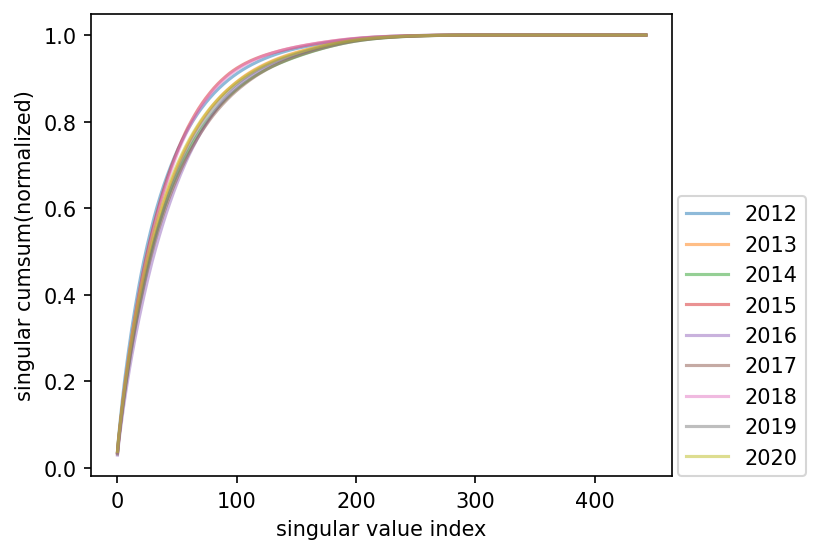

In [4]:
test_id = "nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_"
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': np.float64(0.4632452635422548),
 '2013': np.float64(0.47986298006084493),
 '2014': np.float64(0.46125682415531477),
 '2015': np.float64(0.4672404643840503),
 '2016': np.float64(0.4290361281506142),
 '2017': np.float64(0.4374336897944233),
 '2018': np.float64(0.449221766773663),
 '2019': np.float64(0.4295127090329538),
 '2020': np.float64(0.437953179509767)}

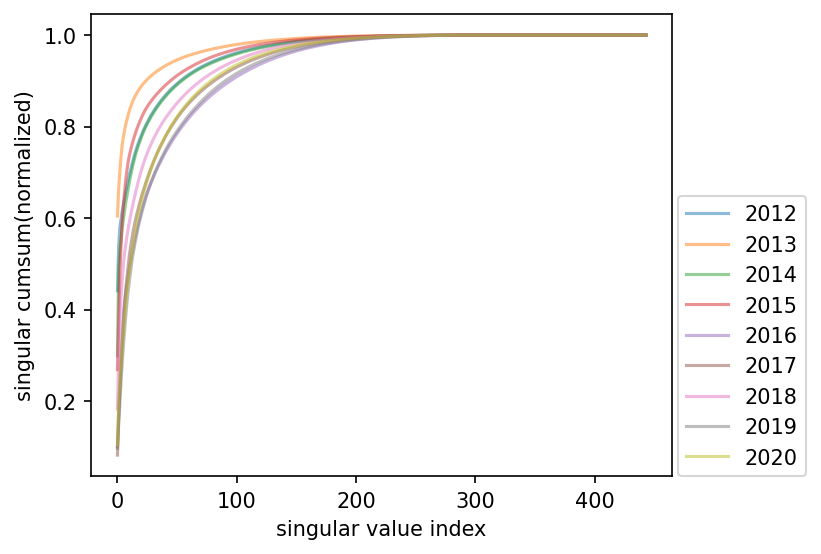

In [5]:
test_id = "nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_"
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=True)
gn_dic

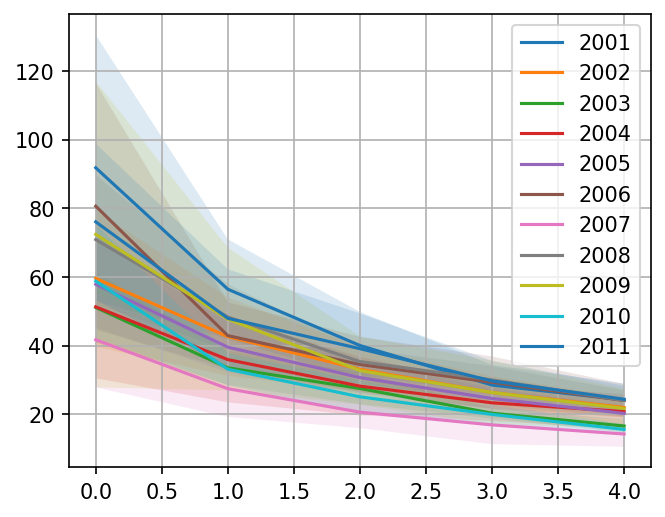

In [67]:
jacs = {i:[] for i in range(720, 852, 12)}
seeds = 10
for expid in range(seeds):
    test_id = "long_term_forecast_data_mean_996_37_iTransformer_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_ebtimeF_dtTrue_Exp_"+str(expid)
    for i in range(720, 852, 12):
        str_i = f'{i:04d}'
        mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy').reshape(12*36, -1).astype(float)
        u, s, vt = np.linalg.svd(mat)
        jacs[i].append(s) 

plt.figure(figsize=(5,4),dpi=150)
for i in range(720, 852, 12):
    jac_arr = np.array(jacs[i])
    jac_mean = np.mean(jac_arr, axis=0)
    jac_std = np.std(jac_arr, axis=0)
    
    
    plt.plot(jac_mean[:5], label=str(1941+i//12))
    plt.fill_between(range(5), jac_mean[:5]+jac_std[:5], jac_mean[:5]-jac_std[:5], alpha=0.15)
plt.grid()
plt.legend()